In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from eden.util import configure_logging
import logging
configure_logging(logging.getLogger(),verbosity=1)


In [2]:
# get data
from eden.converter.graph.gspan import gspan_to_eden
from itertools import islice
!head -12 'RF00005.fa'
#/home/ikea/GraphLearn/graphlearn/abstract_graphs/


>AB003409.1/96-167
GGGCCCAUAGCUCAGUGGUAGAGUGCCUCCUUUGCAAGGAGGAUGCCCUGGGUUCGAAUC
CCAGUGGGUCCA
>AB009835.1/1-71
CAUUAGAUGACUGAAAGCAAGUACUGGUCUCUUAAACCAUUUAAUAGUAAAUUAGCACUU
ACUUCUAAUGA
>AB013372.1/8-81
GCGCCCGUAGCUCAAUUGGAUAGAGCGUUUGACUACGGAUCAAAAGGUUAGGGGUUCGAC
UCCUCUCGGGCGCG
>AB013373.1/3754-3825
GCGGAAGUAGUUCAGUGGUAGAACACCACCUUGCCAAGGUGGGGGUCGCGGGUUCGAAUC
CCGUCUUCCGCU


In [3]:
st1= "GGGCCCAUAGCUCAGUGGUAGAGUGCCUCCUUUGCAAGGAGGAUGCCCUGGGUUCGAAUCCCAGUGGGUCCA"
st2="GCGGAAGUAGUUCAGUGGUAGAACACCACCUUGCCAAGGUGGGGGUCGCGGGUUCGAAUCCCGUCUUCCGCU"
!echo "$st2" | RNAfold

GCGGAAGUAGUUCAGUGGUAGAACACCACCUUGCCAAGGUGGGGGUCGCGGGUUCGAAUCCCGUCUUCCGCU
(((((((..((((.......)))).(((((((...))))))).....(((((.......)))))))))))). (-30.00)


In [4]:
struct="(((((((..((((.......)))).(((((((...))))))).....(((((.......))))))))))))."

import graphlearn.abstract_graphs.forgi.bulge_graph as lol
bg = lol.BulgeGraph()
bg.from_dotbracket(struct, None)
forgi = bg.to_bg_string()


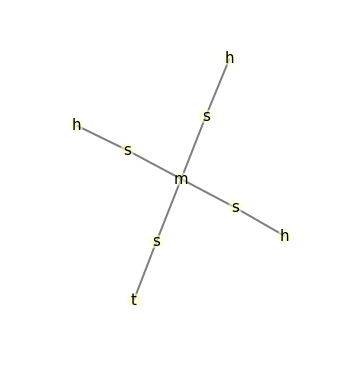

In [5]:
import networkx as nx
import graphlearn.utils.draw as draw

def make_node_set(numbers):
    numbers=map(int,numbers)
    ans=set()
    while len(numbers)>1:
        a,b = numbers[:2]
        numbers=numbers[2:]
        for n in range(a-1,b): ans.add(n) # should be range a,b+1 but the biologists are weired
    return ans


def getpairs(graph,mergelist,node):
    print 'asd',graph.node[node]['contracted']
    low=[]
    high=[]
    current_min= min( graph.node[node]['contracted'] )    
    current_max= max( graph.node[node]['contracted'] )
    for e in mergelist:
        print 'zomg',graph.node[e]['contracted']
        v = min(graph.node[e]['contracted'])
        if v > current_max or v < current_min:
            high.append(e)
        else:
            low.append(e)
    if len(low) == 2:
        yield low
    if len(high) == 2:
        yield high

def get_pairs(things):
    current=[]
    for thing in things:
        if thing[0]=='m':
            current.append(thing)
        if len(current)==2:
            yield current
            current = []
        
    
def forgi_to_graph(forgi):
    g=nx.Graph()
    fni={} # forgi name to networkx node id

    for l in forgi.split('\n')[:-1]:
        line= l.split()
        if line[0] not in ['define','connect']:
            continue


        if line[0]=='define':

            # get necessary attributes for a node
            label=line[1][0]
            id=line[1]
            myset=make_node_set(line[2:])
            node_id=len(g)

            # build a node and document its id
            g.add_node(node_id)
            fni[id]=node_id
            g.node[node_id].update( {'label':label, 'contracted':myset}  )


        if line[0]=='connect':
            # get the node that will connect to things:
            hero= fni[ line[1] ]
            for fn in line[2:]:
                g.add_edge(hero, fni[fn])
                
            g.node[fni[line[1]]]['multipairs']=[]
            for a,b in get_pairs(line[2:]):
                g.node[fni[line[1]]]['multipairs'].append( (fni[a],fni[b]) )
    return g


def connect_multiloop(g):
    
    merge_dict={}
    for node,d in g.nodes(data=True):
        if d['label'] == 's':
            for a,b in g.node[node]['multipairs']:
                # finding real names...
                while a not in g:
                    a=merge_dict[a]
                while b not in g:
                    b=merge_dict[b]
                if a==b:
                    continue
                merge_dict[b]=a
                merge(g,a,b)
                

def merge(graph, node, node2):
    '''
    merge node2 into the node.
    input nodes are strings,
    node is the king
    '''
    for n in graph.neighbors(node2):
        graph.add_edge(node, n)
    
    graph.node[node]['contracted'].update(graph.node[node2]['contracted'])
    graph.remove_node(node2)

            
g=forgi_to_graph(forgi)
#draw.graphlearn_draw(g, vertex_label='id')        
connect_multiloop(g)    
draw.graphlearn_draw(g)  

In [6]:


s=set(range(3))

In [7]:
min(s)

0

In [20]:

def feedme(s):
    s=!RNAfold --noPS < RF00005.fa
    while len(s)>3:
        a,b,c = s[:3] 
        s=s[3:]
        c=c.split()[0]
        yield a,b,c  # name, seq, str
def feedme(s):
    stru='((..((..))..((..))))'
    yield 'blub','0'*len(stru),stru




blub 0000000000000000 ((..(())..(())))


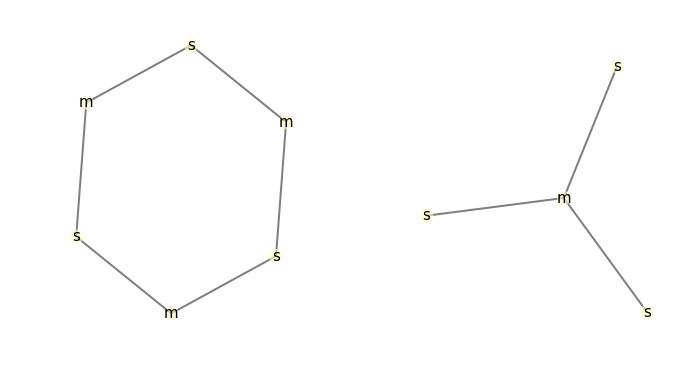

In [21]:
import graphlearn.abstract_graphs.forgi.bulge_graph as lol
import itertools

rez=[]

for name,seq,struct in itertools.islice(feedme(s),5):
    print name,seq,struct
    bg = lol.BulgeGraph()
    bg.from_dotbracket(struct, None)
    forgi = bg.to_bg_string()
    g=forgi_to_graph(forgi)
    g2=g.copy()
    connect_multiloop(g2)    
    draw.graphlearn_draw([g,g2])
    rez.append((g2,seq,struct))
    


((..(())..(())))


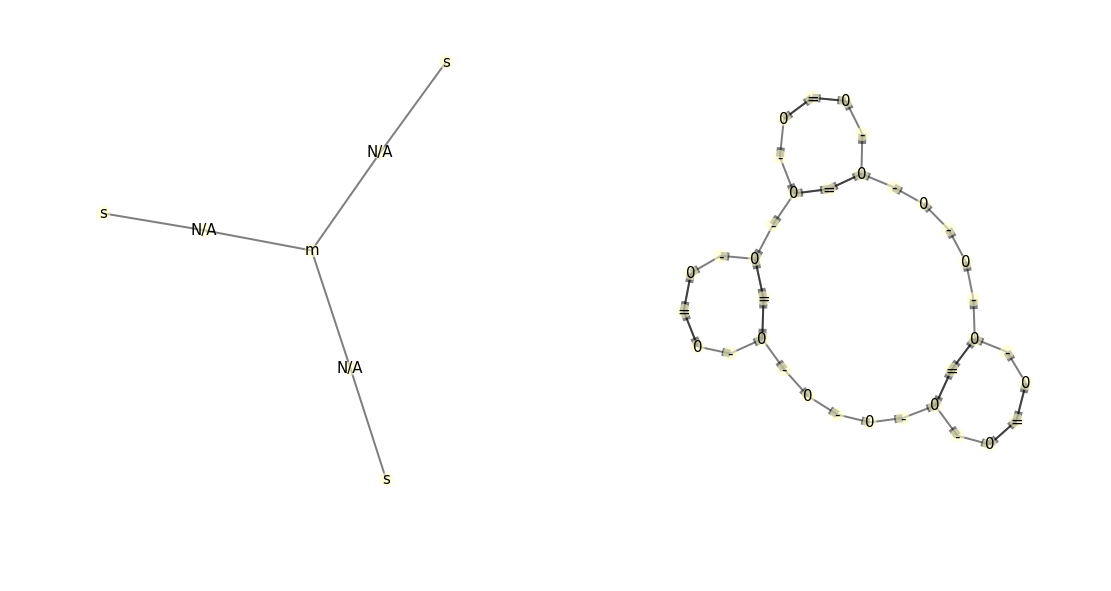

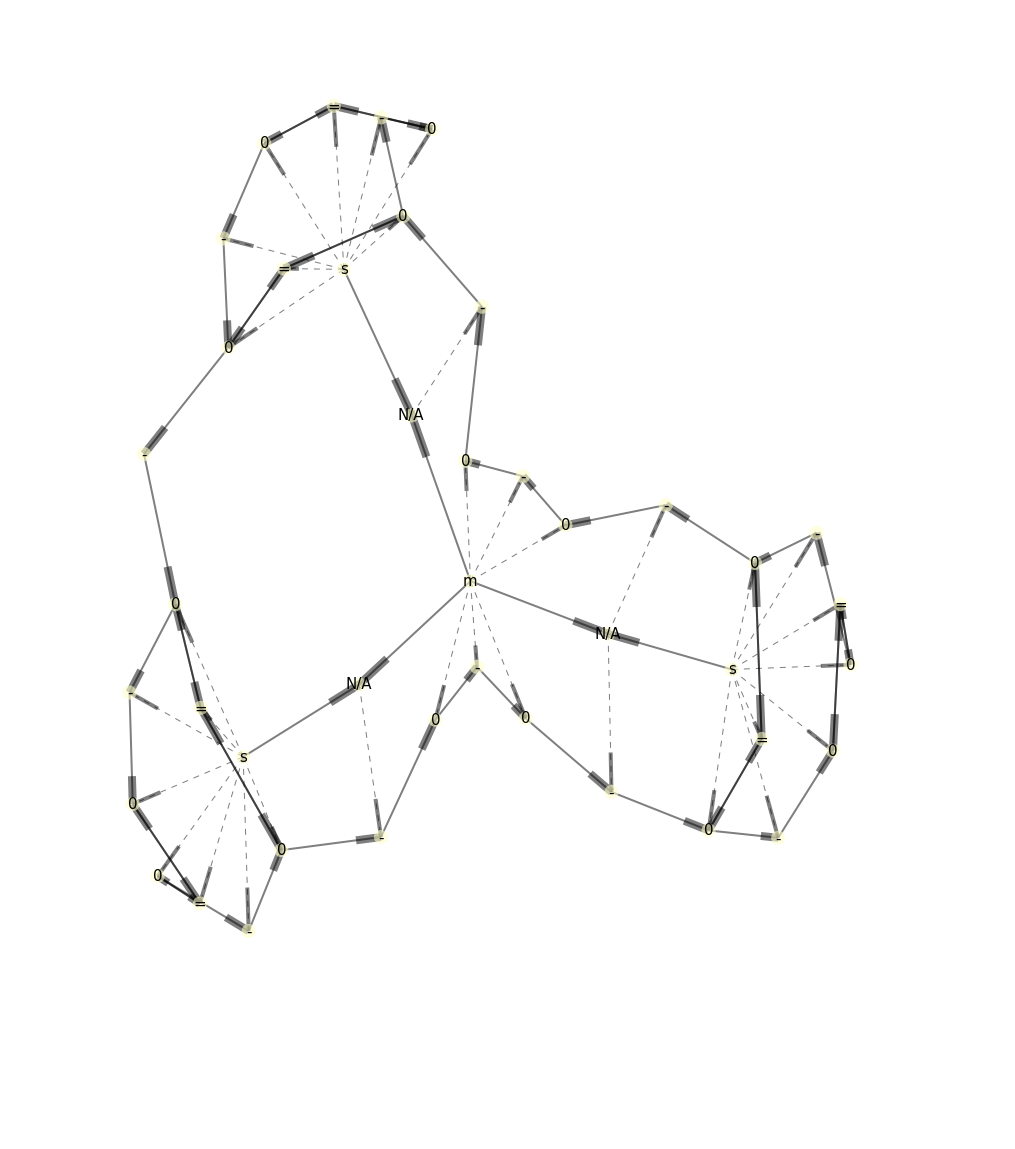

In [22]:
"""
THE PLAN
create underlying graph.
expand and direct
see if we can map 
"""
def ubersamplers_edge_parent_finder(abstract,graph):
    # find out to which abstract node the edges belong
    # finding out where the edge-nodes belong, because the contractor cant possibly do this
    #draw.graphlearn_draw([abstract,graph],size=10, contract=False,vertex_label='id')
    getabstr = {contra: node for node, d in abstract.nodes(data=True) for contra in d.get('contracted', [])}
    #print getabstr
    for n, d in graph.nodes(data=True):
        if 'edge' in d:
            # if we have found an edge node...
            # lets see whos left and right of it:
            zomg= graph.neighbors(n)
            #print zomg
            #draw.draw_center(graph,1,20,contract=False,size=20)
            n1, n2 = zomg
            
    
            # case1: ok those belong to the same gang so we most likely also belong there.
            if getabstr[n1] == getabstr[n2]:
                abstract.node[getabstr[n1]]['contracted'].add(n)

            # case2: neighbors belong to different gangs...
            else:
                blub = set(abstract.neighbors(getabstr[n1])) & set(abstract.neighbors(getabstr[n2]))
                for blob in blub:
                    if 'contracted' in abstract.node[blob]:
                        abstract.node[blob]['contracted'].add(n)
                    else:
                        abstract.node[blob]['contracted'] = set([n])
    return abstract



def create_nesting(astr,graph):
    z=nx.disjoint_union(graph,astr)
    for node,d in z.nodes(data=True):
        for c in d.get('contracted',[]):
            z.add_edge(node,c,{'nesting':True})
    return z
        

import eden.converter.rna as conv
from eden.graph import Vectorizer
import graphlearn.abstract_graphs.rnasampler as rna
v=Vectorizer()

for g,se,st in rez:
    print st
    
    # create a base_graph , expand
    base_graph=conv.sequence_dotbracket_to_graph(seq_info=se, seq_struct=st)
    bg=v._edge_to_vertex_transform(base_graph)
    g=v._edge_to_vertex_transform(g)
    g=ubersamplers_edge_parent_finder(g,bg)
    bg=rna.expanded_rna_graph_to_digraph(bg)
    
    z=create_nesting(g,bg)
    draw.graphlearn_draw([g,bg],size=10, contract=False)
    draw.graphlearn_draw(z,size=20, contract=False)
    
    
    

In [ ]:
g=nx.path_graph(5)
f=nx.path_graph(4)
z=nx.disjoint_union(g,f)
draw.graphlearn_draw(z,vertex_label='id')

In [ ]:
r=range(4)
map(str,r)